In [1]:
from google.colab import drive
import pandas as pd
import numpy as np

# Google Drive'ı bağla
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd

# Veri birleştirme
# Yolun tanımlanması
input_directory_path = '/content/drive/My Drive/Bitirme/window_it/'

# Tüm verileri tutacak boş bir liste
all_data = []

# Belirtilen dizindeki her CSV dosyasını tek tek oku ve DataFrame'e dönüştür
for file_name in os.listdir(input_directory_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(input_directory_path, file_name)
        df = pd.read_csv(file_path)
        all_data.append(df)

# Tek bir DataFrame olarak birleştir
combined_df = pd.concat(all_data, ignore_index=True)

In [3]:
combined_df.dropna(inplace=True)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Özelliklerin ve hedefin belirlenmesi
features_autoencoder = [
    'HghRslutionTotalVehicleDistance_mean', 'TachographVehicleSpeed_mean',
    'EngSpeed_mean', 'ActualEngPercentTorque_mean', 'AccelPedalPos1_mean',
    'BrakePedalPos_mean', 'PCCM_Slope_mean', 'DStgy_dmRdcAgAct_mean',
    'EngOilTemp1_mean', 'EngCoolantTemp_mean', 'GrossCombinationVehicleWeight_mean',
    'EngTotalFuelUsed_mean'
]
target_autoencoder = 'avg_fuel_consumption'

# Anomali olmayan verileri filtreleme
cleaned_df_autoencoder = combined_df[combined_df[target_autoencoder] > 0]
features_df_autoencoder = cleaned_df_autoencoder[features_autoencoder]

# Normalizasyon
features_normalized_autoencoder = (features_df_autoencoder - features_df_autoencoder.mean()) / features_df_autoencoder.std()

# NaN kontrolü
if features_normalized_autoencoder.isnull().values.any():
    features_normalized_autoencoder = features_normalized_autoencoder.fillna(0)


Epoch 1/50
72/72 [==============================] - 1s 6ms/step - loss: 1.1247 - val_loss: 1.1581
Epoch 2/50
72/72 [==============================] - 0s 3ms/step - loss: 0.8813 - val_loss: 0.9362
Epoch 3/50
72/72 [==============================] - 0s 3ms/step - loss: 0.7416 - val_loss: 0.8320
Epoch 4/50
72/72 [==============================] - 0s 3ms/step - loss: 0.6740 - val_loss: 0.7776
Epoch 5/50
72/72 [==============================] - 0s 3ms/step - loss: 0.6367 - val_loss: 0.7493
Epoch 6/50
72/72 [==============================] - 0s 3ms/step - loss: 0.6151 - val_loss: 0.7328
Epoch 7/50
72/72 [==============================] - 0s 3ms/step - loss: 0.6019 - val_loss: 0.7223
Epoch 8/50
72/72 [==============================] - 0s 3ms/step - loss: 0.5931 - val_loss: 0.7151
Epoch 9/50
72/72 [==============================] - 0s 3ms/step - loss: 0.5869 - val_loss: 0.7097
Epoch 10/50
72/72 [==============================] - 0s 3ms/step - loss: 0.5824 - val_loss: 0.7058
Epoch 11/50
72/72 [

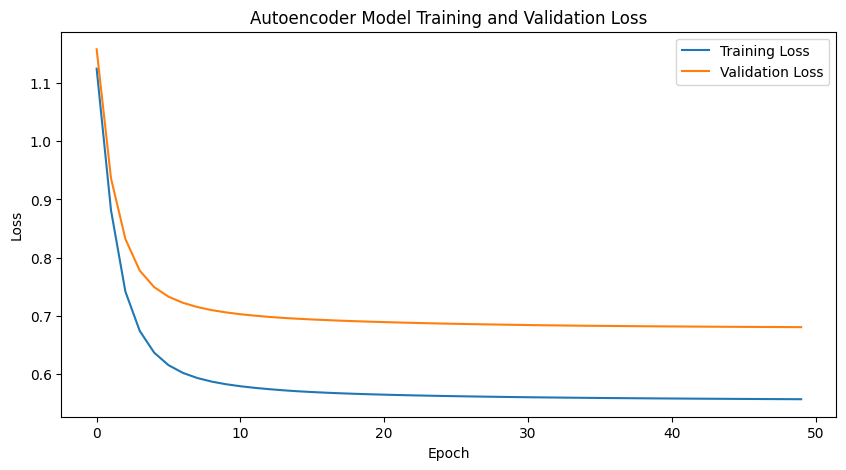

In [5]:
# Model yapılandırması
input_dim_autoencoder = features_normalized_autoencoder.shape[1]
encoding_dim = 32

input_layer = Input(shape=(input_dim_autoencoder,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim_autoencoder, activation='sigmoid')(encoded)
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Model eğitimi
history_autoencoder = autoencoder.fit(
    features_normalized_autoencoder,
    features_normalized_autoencoder,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_split=0.25
)

# Eğitim sonuçlarını çizdirme
plt.figure(figsize=(10, 5))
plt.plot(history_autoencoder.history['loss'], label='Training Loss')
plt.plot(history_autoencoder.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Test setinde yeniden oluşturma hatalarını hesaplama
predictions = autoencoder.predict(features_normalized)
mse = np.mean(np.power(features_normalized - predictions, 2), axis=1)

NameError: name 'features_normalized' is not defined

In [6]:
# Yeniden yapılandırma hataları hesaplama
predictions_autoencoder = autoencoder.predict(features_normalized_autoencoder)
reconstruction_error_autoencoder = np.mean(np.power(features_normalized_autoencoder - predictions_autoencoder, 2), axis=1)

# adjusted_df_autoencoder DataFrame'ini oluştur
adjusted_df_autoencoder = cleaned_df_autoencoder.copy()

# MSE'yi DataFrame'e ekleyin
adjusted_df_autoencoder['mse'] = reconstruction_error_autoencoder

# MSE'nin istatistiksel özetini alın
print(adjusted_df_autoencoder['mse'].describe())


763/763 [==============================] - 1s 1ms/step
count    24388.000000
mean         0.587534
std          1.216373
min          0.004348
25%          0.190240
50%          0.322184
75%          0.592132
max         29.526638
Name: mse, dtype: float64


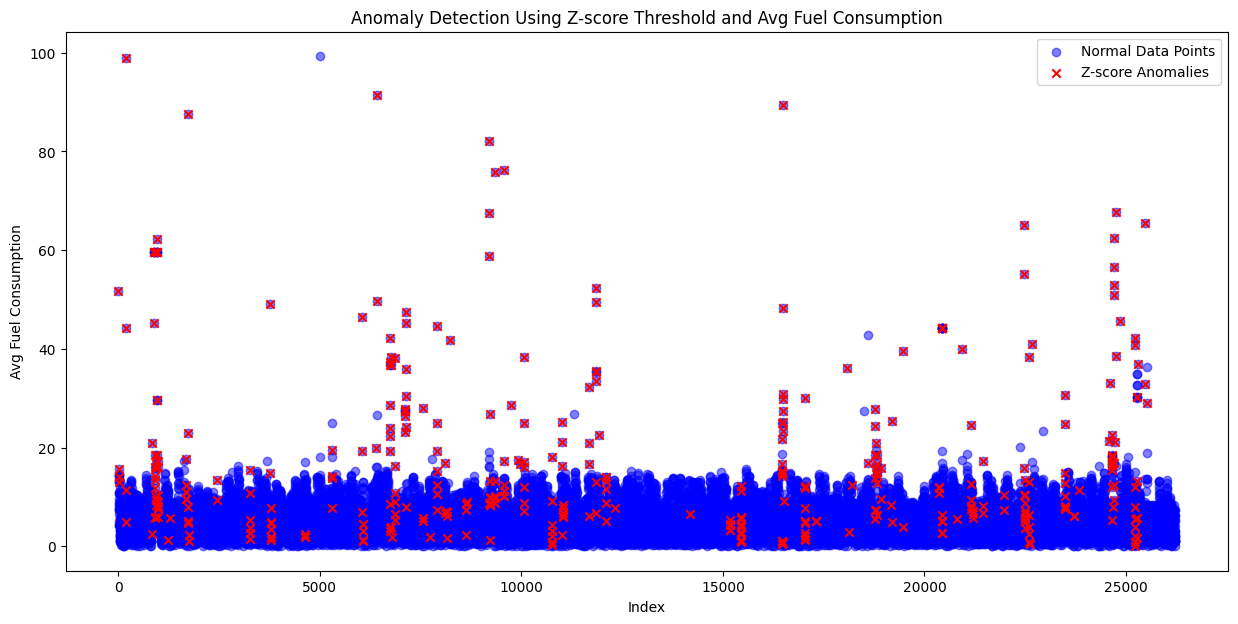

In [7]:
# Z-Score Tabanlı Threshold ile Anomali Tespiti
reconstruction_errors_zscore_autoencoder = zscore(reconstruction_error_autoencoder)
zscore_threshold_autoencoder = 3.0
zscore_anomalies_autoencoder = np.abs(reconstruction_errors_zscore_autoencoder) > zscore_threshold_autoencoder

adjusted_df_autoencoder['is_anomaly_zscore'] = 0
adjusted_df_autoencoder.loc[zscore_anomalies_autoencoder, 'is_anomaly_zscore'] = 1

plt.figure(figsize=(15, 7))
plt.scatter(adjusted_df_autoencoder.index, adjusted_df_autoencoder['avg_fuel_consumption'], c='blue', label='Normal Data Points', alpha=0.5)
plt.scatter(adjusted_df_autoencoder.index[adjusted_df_autoencoder['is_anomaly_zscore'] == 1], adjusted_df_autoencoder['avg_fuel_consumption'][adjusted_df_autoencoder['is_anomaly_zscore'] == 1], c='red', marker='x', label='Z-score Anomalies')
plt.title('Anomaly Detection Using Z-score Threshold and Avg Fuel Consumption')
plt.xlabel('Index')
plt.ylabel('Avg Fuel Consumption')
plt.legend()
plt.show()


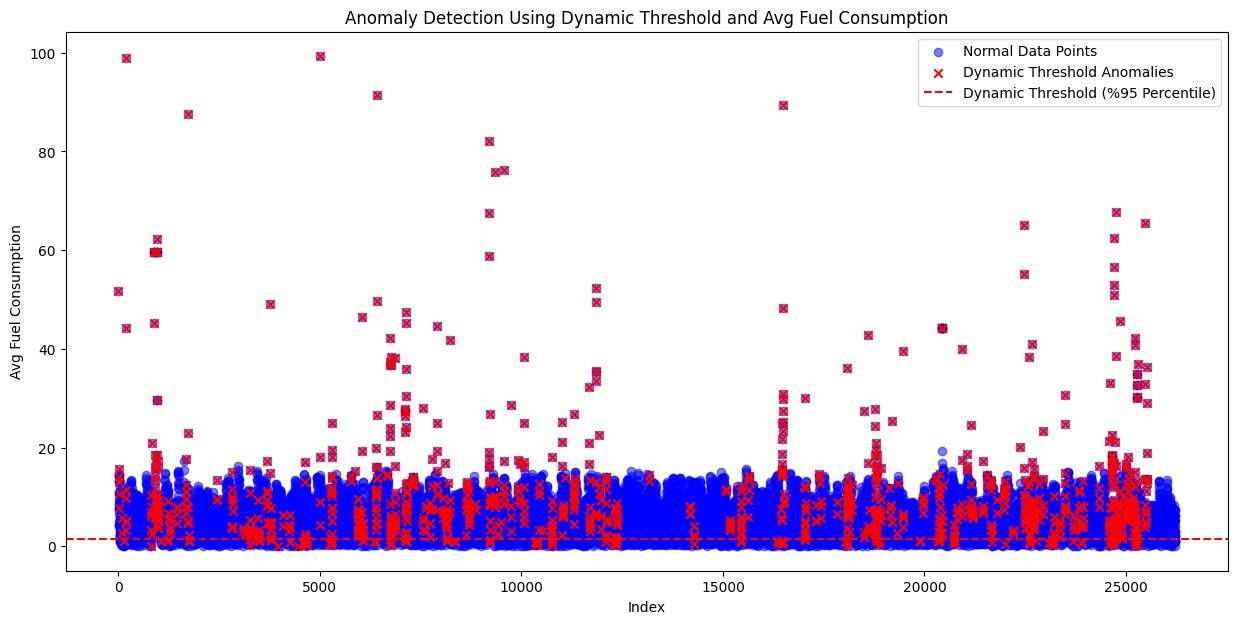

In [8]:
# Dinamik Threshold (Percentile Tabanlı) ile Anomali Tespiti
dynamic_threshold_autoencoder = np.percentile(reconstruction_error_autoencoder, 95)
dynamic_anomalies_autoencoder = reconstruction_error_autoencoder > dynamic_threshold_autoencoder

adjusted_df_autoencoder['is_anomaly_dynamic'] = 0
adjusted_df_autoencoder.loc[dynamic_anomalies_autoencoder, 'is_anomaly_dynamic'] = 1

plt.figure(figsize=(15, 7))
plt.scatter(adjusted_df_autoencoder.index, adjusted_df_autoencoder['avg_fuel_consumption'], c='blue', label='Normal Data Points', alpha=0.5)
plt.scatter(adjusted_df_autoencoder.index[adjusted_df_autoencoder['is_anomaly_dynamic'] == 1], adjusted_df_autoencoder['avg_fuel_consumption'][adjusted_df_autoencoder['is_anomaly_dynamic'] == 1], c='red', marker='x', label='Dynamic Threshold Anomalies')
plt.axhline(y=dynamic_threshold_autoencoder, color='red', linestyle='--', label='Dynamic Threshold (%95 Percentile)')
plt.title('Anomaly Detection Using Dynamic Threshold and Avg Fuel Consumption')
plt.xlabel('Index')
plt.ylabel('Avg Fuel Consumption')
plt.legend()
plt.show()


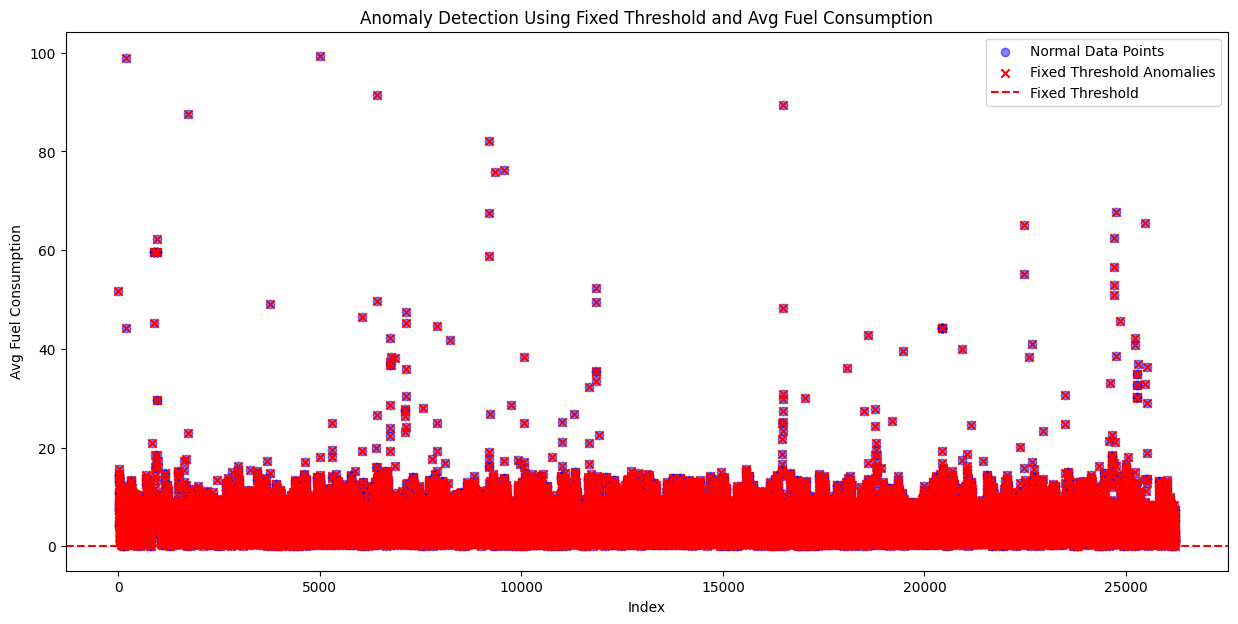

In [9]:
# Sabit Threshold ile Anomali Tespiti
fixed_threshold_autoencoder = 0.01
fixed_anomalies_autoencoder = reconstruction_error_autoencoder > fixed_threshold_autoencoder

adjusted_df_autoencoder['is_anomaly_fixed'] = 0
adjusted_df_autoencoder.loc[fixed_anomalies_autoencoder, 'is_anomaly_fixed'] = 1

plt.figure(figsize=(15, 7))
plt.scatter(adjusted_df_autoencoder.index, adjusted_df_autoencoder['avg_fuel_consumption'], c='blue', label='Normal Data Points', alpha=0.5)
plt.scatter(adjusted_df_autoencoder.index[adjusted_df_autoencoder['is_anomaly_fixed'] == 1], adjusted_df_autoencoder['avg_fuel_consumption'][adjusted_df_autoencoder['is_anomaly_fixed'] == 1], c='red', marker='x', label='Fixed Threshold Anomalies')
plt.axhline(y=fixed_threshold_autoencoder, color='red', linestyle='--', label='Fixed Threshold')
plt.title('Anomaly Detection Using Fixed Threshold and Avg Fuel Consumption')
plt.xlabel('Index')
plt.ylabel('Avg Fuel Consumption')
plt.legend()
plt.show()


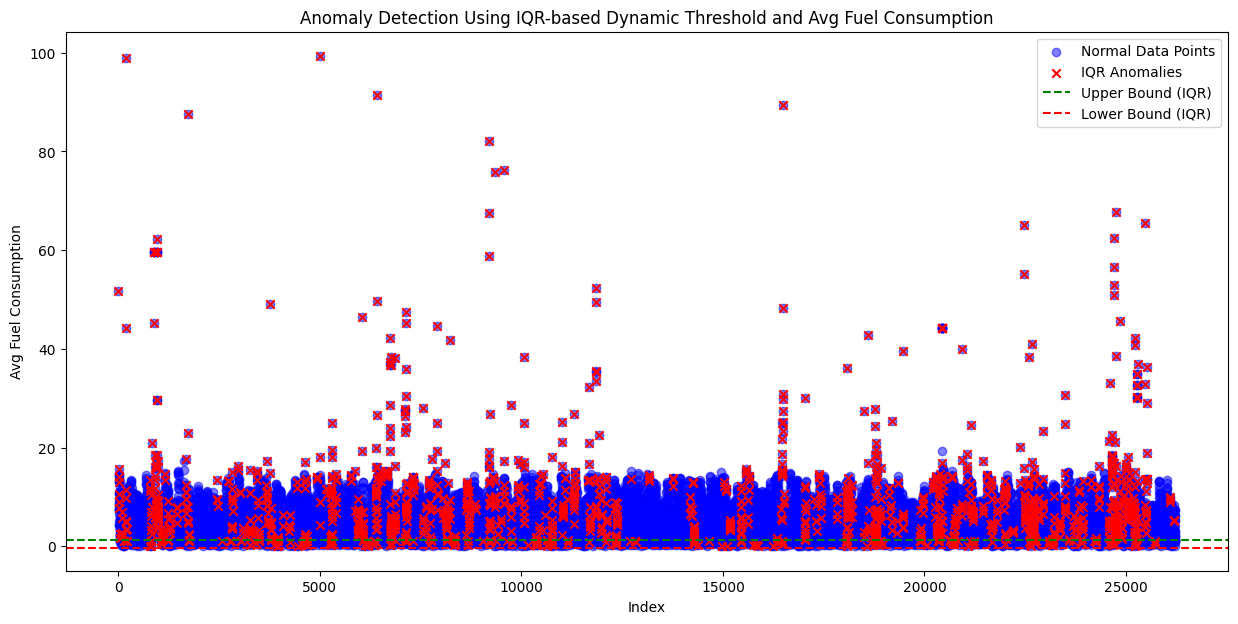

In [10]:
# IQR Tabanlı Threshold ile Anomali Tespiti
Q1_autoencoder = np.percentile(reconstruction_error_autoencoder, 25)
Q3_autoencoder = np.percentile(reconstruction_error_autoencoder, 75)
IQR_autoencoder = Q3_autoencoder - Q1_autoencoder

iqr_threshold_upper_autoencoder = Q3_autoencoder + 1.5 * IQR_autoencoder
iqr_threshold_lower_autoencoder = Q1_autoencoder - 1.5 * IQR_autoencoder

iqr_anomalies_autoencoder = (reconstruction_error_autoencoder > iqr_threshold_upper_autoencoder) | (reconstruction_error_autoencoder < iqr_threshold_lower_autoencoder)

adjusted_df_autoencoder['is_anomaly_iqr'] = 0
adjusted_df_autoencoder.loc[iqr_anomalies_autoencoder, 'is_anomaly_iqr'] = 1

plt.figure(figsize=(15, 7))
plt.scatter(adjusted_df_autoencoder.index, adjusted_df_autoencoder['avg_fuel_consumption'], c='blue', label='Normal Data Points', alpha=0.5)
plt.scatter(adjusted_df_autoencoder.index[adjusted_df_autoencoder['is_anomaly_iqr'] == 1], adjusted_df_autoencoder['avg_fuel_consumption'][adjusted_df_autoencoder['is_anomaly_iqr'] == 1], c='red', marker='x', label='IQR Anomalies')
plt.axhline(y=iqr_threshold_upper_autoencoder, color='green', linestyle='--', label='Upper Bound (IQR)')
plt.axhline(y=iqr_threshold_lower_autoencoder, color='red', linestyle='--', label='Lower Bound (IQR)')
plt.title('Anomaly Detection Using IQR-based Dynamic Threshold and Avg Fuel Consumption')
plt.xlabel('Index')
plt.ylabel('Avg Fuel Consumption')
plt.legend()
plt.show()


In [ ]:
import pandas as pd

# LSTM IQR anomalilerini içeren CSV dosyasını yükleme
lstm_iqr_anomalies_df = pd.read_csv('/content/drive/My Drive/Bitirme/lstm_iqr_anomalies_indices.csv')

# Autoencoder modelinde IQR anomalilerini belirleme
autoencoder_iqr_anomalies = adjusted_df_autoencoder[adjusted_df_autoencoder['is_anomaly_iqr'] == 1]

# Autoencoder IQR anomalilerinin indekslerini içeren DataFrame oluşturma
autoencoder_iqr_anomalies_indices = autoencoder_iqr_anomalies.index

# LSTM ve Autoencoder IQR anomalilerini karşılaştırma
common_iqr_anomalies = lstm_iqr_anomalies_df[lstm_iqr_anomalies_df['index'].isin(autoencoder_iqr_anomalies_indices)]
unique_lstm_iqr_anomalies = lstm_iqr_anomalies_df[~lstm_iqr_anomalies_df['index'].isin(autoencoder_iqr_anomalies_indices)]
unique_autoencoder_iqr_anomalies = autoencoder_iqr_anomalies[~autoencoder_iqr_anomalies.index.isin(lstm_iqr_anomalies_df['index'])]

# Karşılaştırma sonuçlarını gösterme
print("LSTM ve Autoencoder IQR Anomalileri Karşılaştırması")
print(common_iqr_anomalies)

print("Her iki modelde de ortak olan anomaliler:", common_iqr_anomalies['index'].tolist())
print("Sadece LSTM'de bulunan anomaliler:", unique_lstm_iqr_anomalies['index'].tolist())
print("Sadece Autoencoder'da bulunan anomaliler:", unique_autoencoder_iqr_anomalies.index.tolist())

# Ortak olan ve olmayan anomalilerin sayısını hesaplama
num_common_anomalies = len(common_iqr_anomalies)
num_unique_lstm_anomalies = len(unique_lstm_iqr_anomalies)
num_unique_autoencoder_anomalies = len(unique_autoencoder_iqr_anomalies)

print("Ortak olan anomalilerin sayısı:", num_common_anomalies)
print("Sadece LSTM'de bulunan anomalilerin sayısı:", num_unique_lstm_anomalies)
print("Sadece Autoencoder'da bulunan anomalilerin sayısı:", num_unique_autoencoder_anomalies)


LSTM ve Autoencoder IQR Anomalileri Karşılaştırması
     index
6      192
7      199
23     824
24     825
25     885
..     ...
850  25513
851  25514
852  25515
853  25516
854  25517

[417 rows x 1 columns]
Her iki modelde de ortak olan anomaliler: [192, 199, 824, 825, 885, 886, 887, 888, 913, 914, 915, 916, 917, 926, 927, 964, 965, 966, 967, 969, 970, 971, 973, 989, 1147, 1235, 1236, 1684, 1685, 1686, 1736, 1737, 2458, 2831, 2964, 2965, 3268, 3269, 3450, 3451, 3452, 3458, 3678, 3682, 3774, 3775, 4249, 4629, 4630, 4632, 4633, 4634, 4635, 4935, 4936, 4937, 4938, 5013, 5014, 5296, 5297, 5298, 5301, 5393, 5394, 5395, 5396, 5769, 5770, 5861, 6055, 6056, 6391, 6392, 6393, 6395, 6398, 6399, 6400, 6405, 6406, 6425, 6426, 6427, 6428, 6429, 6452, 6453, 6506, 6613, 6614, 6666, 6667, 6668, 6669, 6735, 6736, 6737, 6738, 6739, 6749, 6750, 6751, 6752, 6753, 6765, 6777, 6796, 6860, 6861, 6862, 7113, 7114, 7115, 7116, 7117, 7118, 7129, 7130, 7131, 7132, 7133, 7139, 7140, 7151, 7155, 7298, 7299, 7300,

In [ ]:
# Save Autoencoder dynamic threshold anomalies indices to a CSV file
dynamic_anomalies_indices_autoencoder = adjusted_df_autoencoder[adjusted_df_autoencoder['is_anomaly_dynamic'] == 1].index
dynamic_anomalies_autoencoder_df = pd.DataFrame(dynamic_anomalies_indices_autoencoder, columns=['index'])
dynamic_anomalies_autoencoder_df.to_csv('/content/drive/My Drive/Bitirme/autoencoder_dynamic_anomalies_indices.csv', index=False)


In [ ]:
# Load the dynamic threshold anomalies indices for both models
dynamic_anomalies_lstm_df = pd.read_csv('/content/drive/My Drive/Bitirme/lstm_dynamic_anomalies_indices.csv')
dynamic_anomalies_autoencoder_df = pd.read_csv('/content/drive/My Drive/Bitirme/autoencoder_dynamic_anomalies_indices.csv')

# Convert indices to sets for comparison
dynamic_anomalies_lstm_set = set(dynamic_anomalies_lstm_df['index'])
dynamic_anomalies_autoencoder_set = set(dynamic_anomalies_autoencoder_df['index'])

# Find common and unique anomalies
common_dynamic_anomalies = dynamic_anomalies_lstm_set.intersection(dynamic_anomalies_autoencoder_set)
unique_lstm_dynamic_anomalies = dynamic_anomalies_lstm_set.difference(dynamic_anomalies_autoencoder_set)
unique_autoencoder_dynamic_anomalies = dynamic_anomalies_autoencoder_set.difference(dynamic_anomalies_lstm_set)

# Display the results
print("Common Dynamic Threshold Anomalies Detected by Both Models:", len(common_dynamic_anomalies))
print("Unique Dynamic Threshold Anomalies Detected by LSTM Model:", len(unique_lstm_dynamic_anomalies))
print("Unique Dynamic Threshold Anomalies Detected by Autoencoder Model:", len(unique_autoencoder_dynamic_anomalies))

# For presentation purposes
result_summary_dynamic = {
    "Common Dynamic Threshold Anomalies Detected by Both Models": len(common_dynamic_anomalies),
    "Unique Dynamic Threshold Anomalies Detected by LSTM Model": len(unique_lstm_dynamic_anomalies),
    "Unique Dynamic Threshold Anomalies Detected by Autoencoder Model": len(unique_autoencoder_dynamic_anomalies)
}

# Display the results in a formatted way
for key, value in result_summary_dynamic.items():
    print(f"{key}: {value}")


Common Dynamic Threshold Anomalies Detected by Both Models: 406
Unique Dynamic Threshold Anomalies Detected by LSTM Model: 813
Unique Dynamic Threshold Anomalies Detected by Autoencoder Model: 814
Common Dynamic Threshold Anomalies Detected by Both Models: 406
Unique Dynamic Threshold Anomalies Detected by LSTM Model: 813
Unique Dynamic Threshold Anomalies Detected by Autoencoder Model: 814


In [11]:
# Z-score Tabanlı Threshold ile Anomali Tespiti
zscore_anomalies_count_autoencoder = adjusted_df_autoencoder['is_anomaly_zscore'].sum()
zscore_normal_count_autoencoder = len(adjusted_df_autoencoder) - zscore_anomalies_count_autoencoder
zscore_anomaly_percentage_autoencoder = (zscore_anomalies_count_autoencoder / len(adjusted_df_autoencoder)) * 100
zscore_normal_percentage_autoencoder = 100 - zscore_anomaly_percentage_autoencoder

# Dinamik Threshold (Percentile Tabanlı) ile Anomali Tespiti
dynamic_anomalies_count_autoencoder = adjusted_df_autoencoder['is_anomaly_dynamic'].sum()
dynamic_normal_count_autoencoder = len(adjusted_df_autoencoder) - dynamic_anomalies_count_autoencoder
dynamic_anomaly_percentage_autoencoder = (dynamic_anomalies_count_autoencoder / len(adjusted_df_autoencoder)) * 100
dynamic_normal_percentage_autoencoder = 100 - dynamic_anomaly_percentage_autoencoder

# Sabit Threshold ile Anomali Tespiti
fixed_anomalies_count_autoencoder = adjusted_df_autoencoder['is_anomaly_fixed'].sum()
fixed_normal_count_autoencoder = len(adjusted_df_autoencoder) - fixed_anomalies_count_autoencoder
fixed_anomaly_percentage_autoencoder = (fixed_anomalies_count_autoencoder / len(adjusted_df_autoencoder)) * 100
fixed_normal_percentage_autoencoder = 100 - fixed_anomaly_percentage_autoencoder

# IQR Tabanlı Threshold ile Anomali Tespiti
iqr_anomalies_count_autoencoder = adjusted_df_autoencoder['is_anomaly_iqr'].sum()
iqr_normal_count_autoencoder = len(adjusted_df_autoencoder) - iqr_anomalies_count_autoencoder
iqr_anomaly_percentage_autoencoder = (iqr_anomalies_count_autoencoder / len(adjusted_df_autoencoder)) * 100
iqr_normal_percentage_autoencoder = 100 - iqr_anomaly_percentage_autoencoder

# Sonuçları DataFrame olarak göstermek
summary_df_autoencoder = pd.DataFrame({
    'Method': ['Z-score Tabanlı', 'Dinamik Threshold', 'Sabit Threshold', 'IQR Tabanlı'],
    'Anomaly Count': [zscore_anomalies_count_autoencoder, dynamic_anomalies_count_autoencoder, fixed_anomalies_count_autoencoder, iqr_anomalies_count_autoencoder],
    'Normal Count': [zscore_normal_count_autoencoder, dynamic_normal_count_autoencoder, fixed_normal_count_autoencoder, iqr_normal_count_autoencoder],
    'Anomaly Percentage (%)': [zscore_anomaly_percentage_autoencoder, dynamic_anomaly_percentage_autoencoder, fixed_anomaly_percentage_autoencoder, iqr_anomaly_percentage_autoencoder],
    'Normal Percentage (%)': [zscore_normal_percentage_autoencoder, dynamic_normal_percentage_autoencoder, fixed_normal_percentage_autoencoder, iqr_normal_percentage_autoencoder]
})

print(summary_df_autoencoder)

              Method  Anomaly Count  Normal Count  Anomaly Percentage (%)  \
0    Z-score Tabanlı            398         23990                1.631950   
1  Dinamik Threshold           1220         23168                5.002460   
2    Sabit Threshold          24383             5               99.979498   
3        IQR Tabanlı           1664         22724                6.823028   

   Normal Percentage (%)  
0              98.368050  
1              94.997540  
2               0.020502  
3              93.176972  


In [12]:
# Save Autoencoder IQR Anomalies Indices
iqr_anomalies_indices_autoencoder = adjusted_df_autoencoder[adjusted_df_autoencoder['is_anomaly_iqr'] == 1].index
pd.DataFrame(iqr_anomalies_indices_autoencoder).to_csv('/content/drive/My Drive/Bitirme/autoencoder_iqr_anomalies1.csv', index=False)

# Save Autoencoder Dynamic Threshold Anomalies Indices
dynamic_anomalies_indices_autoencoder = adjusted_df_autoencoder[adjusted_df_autoencoder['is_anomaly_dynamic'] == 1].index
pd.DataFrame(dynamic_anomalies_indices_autoencoder).to_csv('/content/drive/My Drive/Bitirme/autoencoder_dynamic_anomalies1.csv', index=False)


In [14]:
# Load LSTM IQR Anomalies
lstm_iqr_anomalies = pd.read_csv('/content/drive/My Drive/Bitirme/lstm_iqr_anomalies1.csv', header=None)

# Load Autoencoder IQR Anomalies
autoencoder_iqr_anomalies = pd.read_csv('/content/drive/My Drive/Bitirme/autoencoder_iqr_anomalies1.csv', header=None)

# Load LSTM Dynamic Threshold Anomalies
lstm_dynamic_anomalies = pd.read_csv('/content/drive/My Drive/Bitirme/lstm_dynamic_anomalies1.csv', header=None)

# Load Autoencoder Dynamic Threshold Anomalies
autoencoder_dynamic_anomalies = pd.read_csv('/content/drive/My Drive/Bitirme/autoencoder_dynamic_anomalies1.csv', header=None)



In [15]:
# Calculate Common and Unique IQR Anomalies
common_iqr_anomalies = set(lstm_iqr_anomalies[0]).intersection(set(autoencoder_iqr_anomalies[0]))
unique_lstm_iqr_anomalies = set(lstm_iqr_anomalies[0]) - common_iqr_anomalies
unique_autoencoder_iqr_anomalies = set(autoencoder_iqr_anomalies[0]) - common_iqr_anomalies

print(f"Common IQR Anomalies: {len(common_iqr_anomalies)}")
print(f"Unique IQR Anomalies in LSTM: {len(unique_lstm_iqr_anomalies)}")
print(f"Unique IQR Anomalies in Autoencoder: {len(unique_autoencoder_iqr_anomalies)}")

# Calculate Common and Unique Dynamic Threshold Anomalies
common_dynamic_anomalies = set(lstm_dynamic_anomalies[0]).intersection(set(autoencoder_dynamic_anomalies[0]))
unique_lstm_dynamic_anomalies = set(lstm_dynamic_anomalies[0]) - common_dynamic_anomalies
unique_autoencoder_dynamic_anomalies = set(autoencoder_dynamic_anomalies[0]) - common_dynamic_anomalies

print(f"Common Dynamic Threshold Anomalies: {len(common_dynamic_anomalies)}")
print(f"Unique Dynamic Threshold Anomalies in LSTM: {len(unique_lstm_dynamic_anomalies)}")
print(f"Unique Dynamic Threshold Anomalies in Autoencoder: {len(unique_autoencoder_dynamic_anomalies)}")


Common IQR Anomalies: 413
Unique IQR Anomalies in LSTM: 445
Unique IQR Anomalies in Autoencoder: 1252
Common Dynamic Threshold Anomalies: 404
Unique Dynamic Threshold Anomalies in LSTM: 816
Unique Dynamic Threshold Anomalies in Autoencoder: 817


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


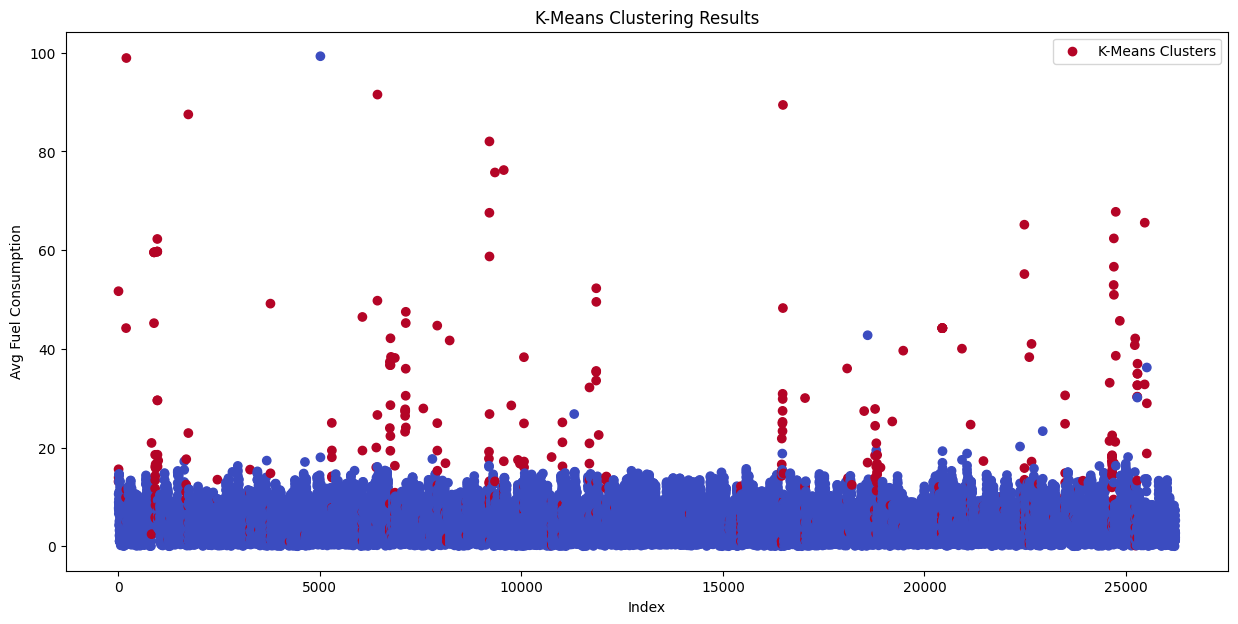

In [ ]:
from sklearn.cluster import KMeans

# K-Means Clustering
kmeans_autoencoder = KMeans(n_clusters=2, random_state=42)
kmeans_labels_autoencoder = kmeans_autoencoder.fit_predict(reconstruction_error_autoencoder.values.reshape(-1, 1))

# K-Means Clustering sonuçlarını DataFrame'e ekleyin
adjusted_df_autoencoder['kmeans_cluster'] = kmeans_labels_autoencoder

# K-Means Clustering sonuçlarını görselleştirme
plt.figure(figsize=(15, 7))
plt.scatter(adjusted_df_autoencoder.index, adjusted_df_autoencoder['avg_fuel_consumption'], c=kmeans_labels_autoencoder, cmap='coolwarm', label='K-Means Clusters')
plt.title('K-Means Clustering Results')
plt.xlabel('Index')
plt.ylabel('Avg Fuel Consumption')
plt.legend()
plt.show()



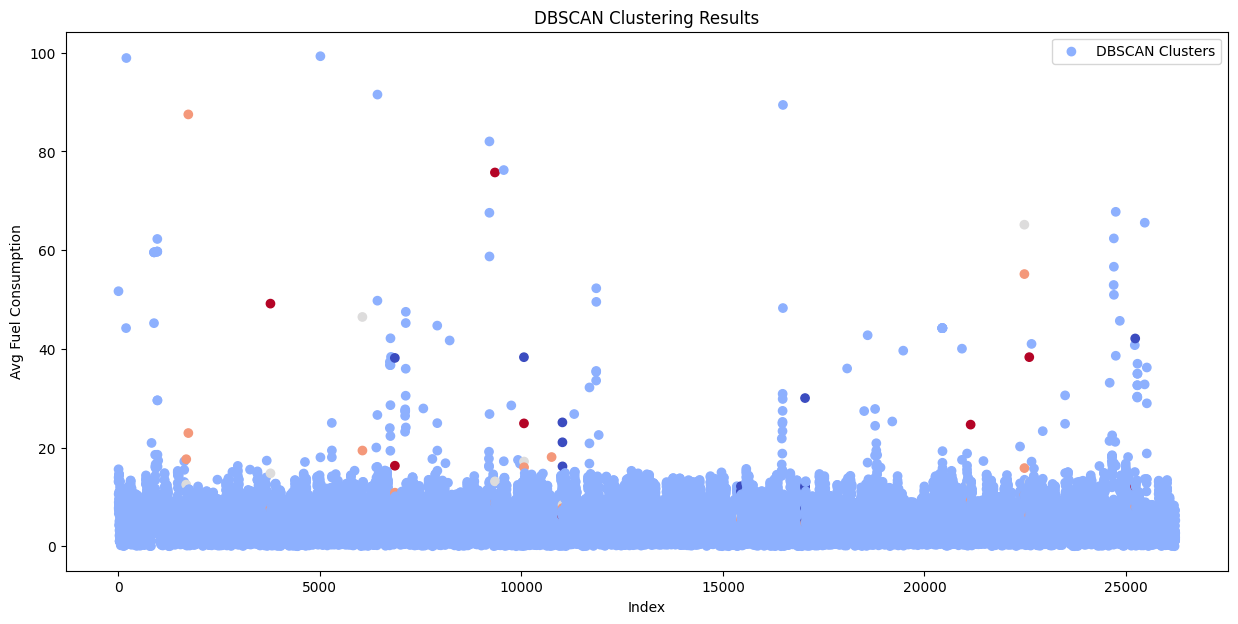

In [ ]:
from sklearn.cluster import DBSCAN

# DBSCAN Clustering
dbscan_autoencoder = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels_autoencoder = dbscan_autoencoder.fit_predict(reconstruction_error_autoencoder.values.reshape(-1, 1))

# DBSCAN Clustering sonuçlarını DataFrame'e ekleyin
adjusted_df_autoencoder['dbscan_cluster'] = dbscan_labels_autoencoder

# DBSCAN Clustering sonuçlarını görselleştirme
plt.figure(figsize=(15, 7))
plt.scatter(adjusted_df_autoencoder.index, adjusted_df_autoencoder['avg_fuel_consumption'], c=dbscan_labels_autoencoder, cmap='coolwarm', label='DBSCAN Clusters')
plt.title('DBSCAN Clustering Results')
plt.xlabel('Index')
plt.ylabel('Avg Fuel Consumption')
plt.legend()
plt.show()


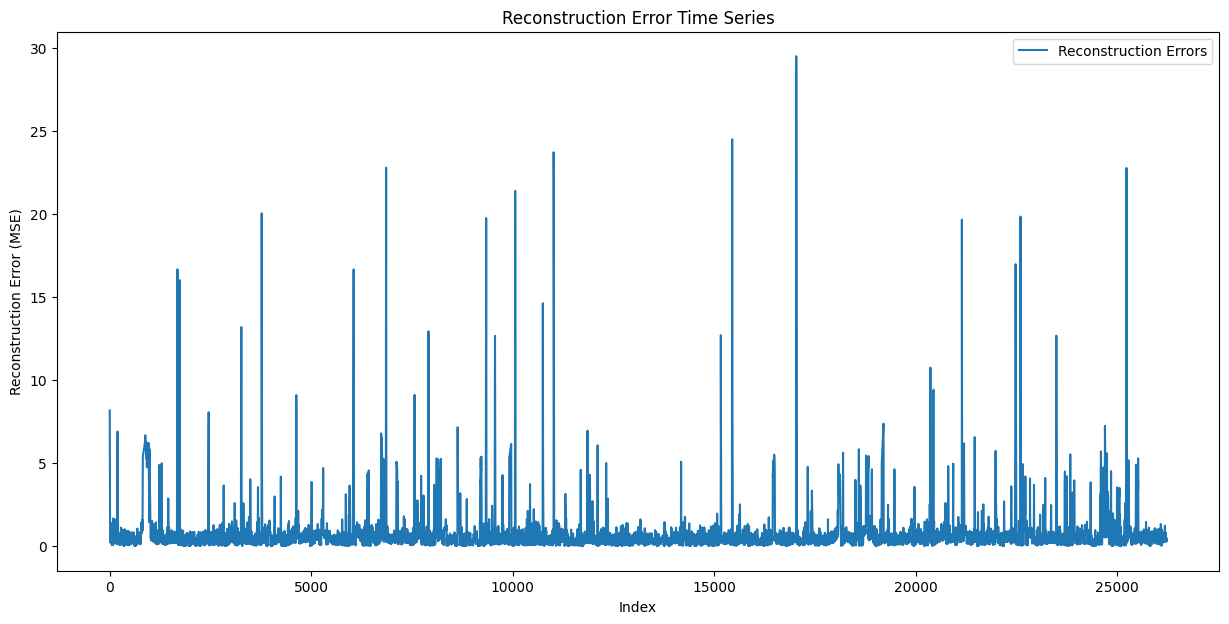

In [ ]:
# Reconstruction Error Time Series
plt.figure(figsize=(15, 7))
plt.plot(adjusted_df_autoencoder.index, reconstruction_error_autoencoder, label='Reconstruction Errors')
plt.title('Reconstruction Error Time Series')
plt.xlabel('Index')
plt.ylabel('Reconstruction Error (MSE)')
plt.legend()
plt.show()


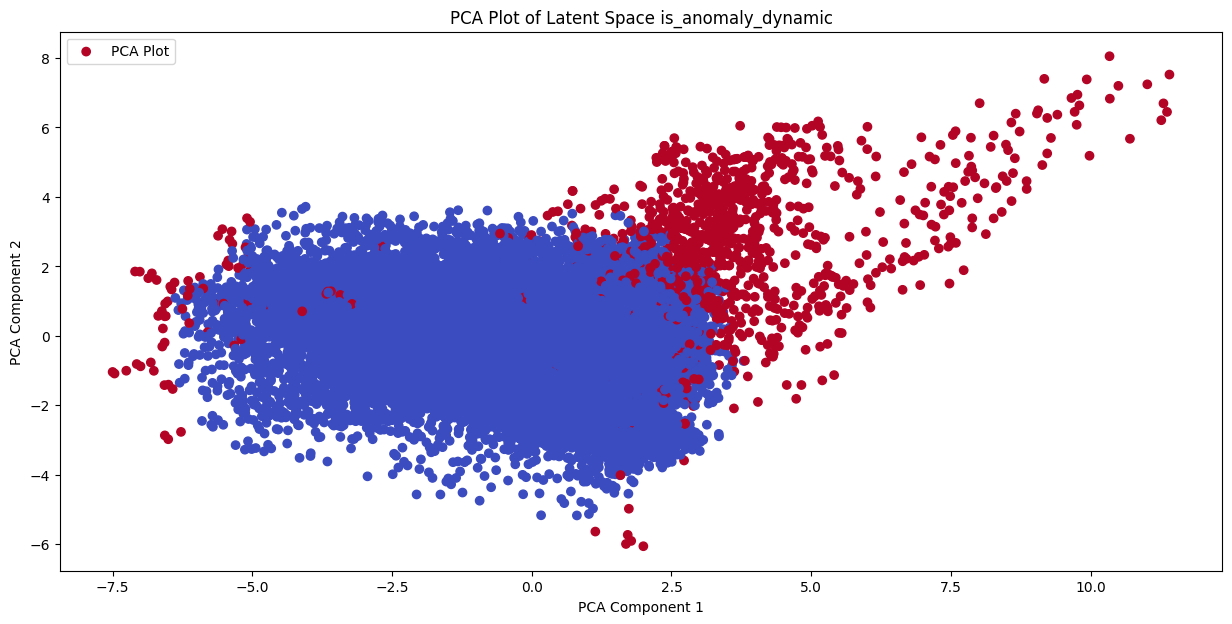

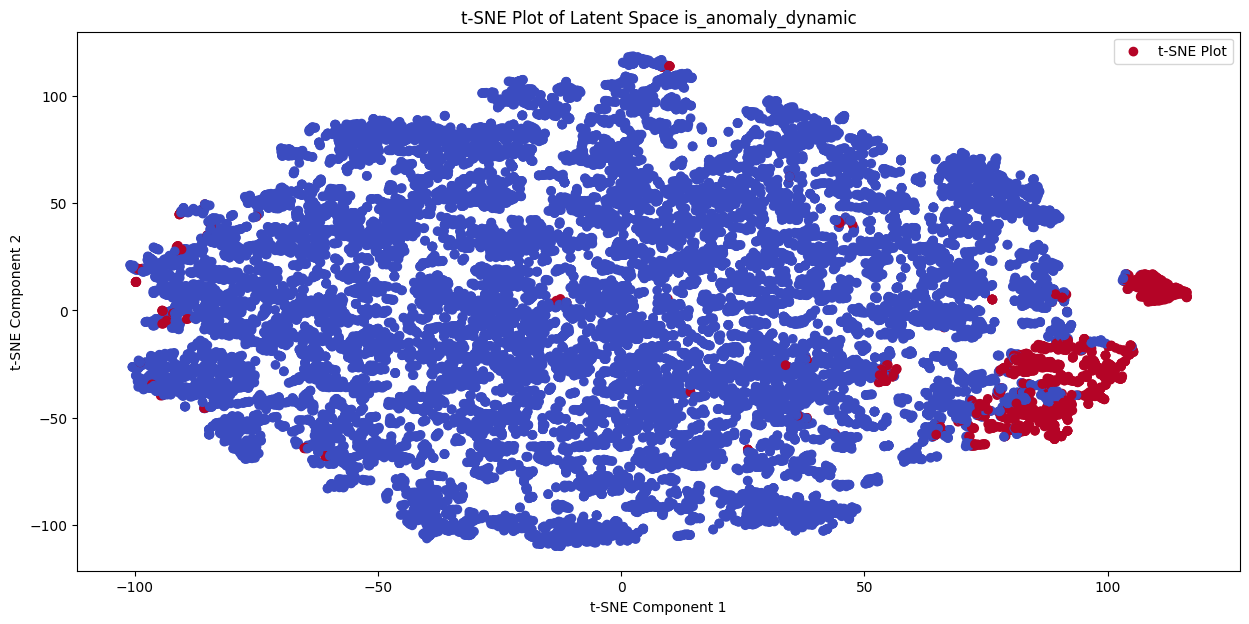

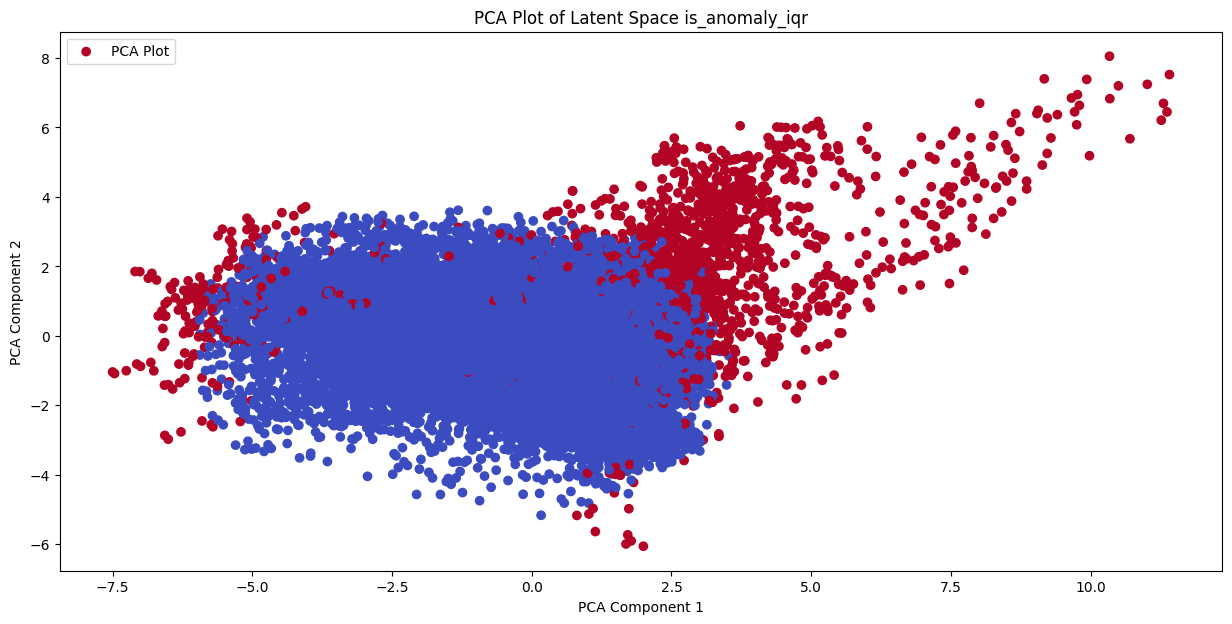

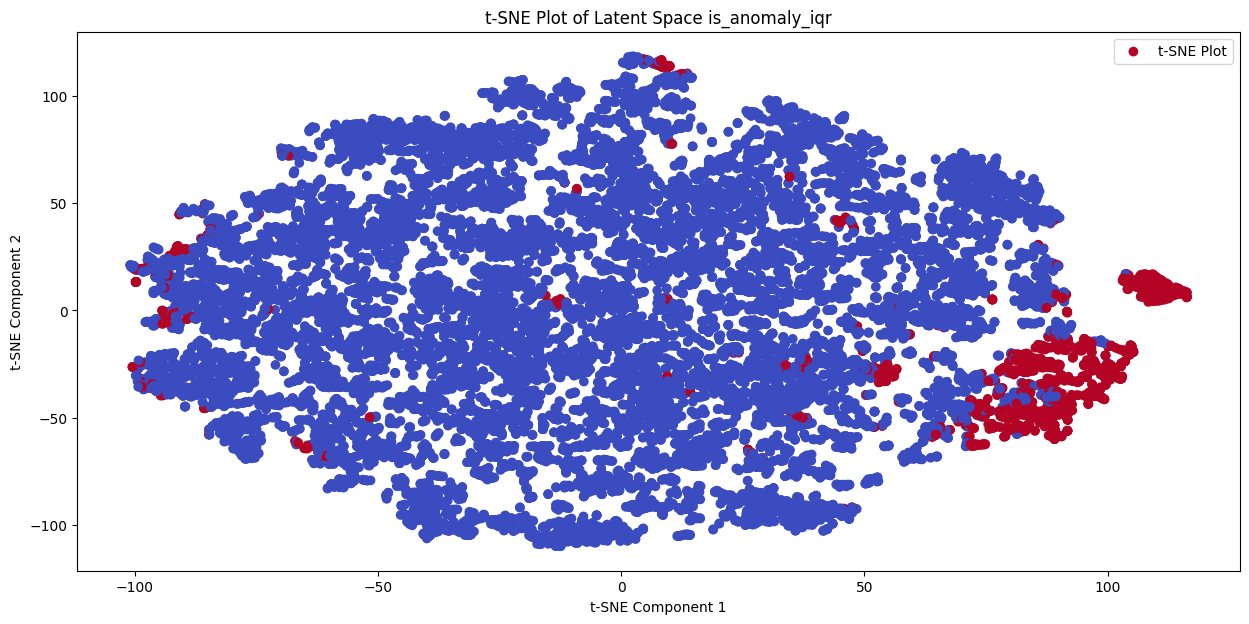

In [ ]:
# PCA Plot
pca_autoencoder = PCA(n_components=2)
pca_result_autoencoder = pca_autoencoder.fit_transform(features_normalized_autoencoder)

plt.figure(figsize=(15, 7))
plt.scatter(pca_result_autoencoder[:, 0], pca_result_autoencoder[:, 1], c=adjusted_df_autoencoder['is_anomaly_dynamic'], cmap='coolwarm', label='PCA Plot')
plt.title('PCA Plot of Latent Space is_anomaly_dynamic')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

# t-SNE Plot
tsne_autoencoder = TSNE(n_components=2, random_state=42)
tsne_result_autoencoder = tsne_autoencoder.fit_transform(features_normalized_autoencoder)

plt.figure(figsize=(15, 7))
plt.scatter(tsne_result_autoencoder[:, 0], tsne_result_autoencoder[:, 1], c=adjusted_df_autoencoder['is_anomaly_dynamic'], cmap='coolwarm', label='t-SNE Plot')
plt.title('t-SNE Plot of Latent Space is_anomaly_dynamic')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

# PCA Plot for IQR-based Threshold
plt.figure(figsize=(15, 7))
plt.scatter(pca_result_autoencoder[:, 0], pca_result_autoencoder[:, 1], c=adjusted_df_autoencoder['is_anomaly_iqr'], cmap='coolwarm', label='PCA Plot')
plt.title('PCA Plot of Latent Space is_anomaly_iqr')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

# t-SNE Plot for IQR-based Threshold
plt.figure(figsize=(15, 7))
plt.scatter(tsne_result_autoencoder[:, 0], tsne_result_autoencoder[:, 1], c=adjusted_df_autoencoder['is_anomaly_iqr'], cmap='coolwarm', label='t-SNE Plot')
plt.title('t-SNE Plot of Latent Space is_anomaly_iqr')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()


In [ ]:
# Dinamik threshold ile anomali olan VehicleID_mean değerleri
vehicle_ids_dynamic_autoencoder = adjusted_df_autoencoder[adjusted_df_autoencoder['is_anomaly_dynamic'] == 1]['VehicleID_mean'].unique()
print("Dynamic Threshold ile Anomali Olan VehicleID_mean Değerleri (Autoencoder):", vehicle_ids_dynamic_autoencoder)

Dynamic Threshold ile Anomali Olan VehicleID_mean Değerleri (Autoencoder): [172.  42. 154. 106.  69.  61. 112.  29.  90.  44.  88.  17.  28.  91.
  60.  56. 132.   9.  75.   5. 166. 147. 134.  46. 148.  62. 165. 140.
  45.  47. 131. 130. 143. 125. 153.  15.  89. 107.  34.  19.  23.  20.
  32. 180.  98. 118.  38. 102. 119.  86.  31.  33.  30.  35.  24.  80.
 177. 108.  95. 111.  84. 116.  25.  94. 114.  78. 175. 136.  10. 164.
 128.   3.  55.  39.  81.  63. 141. 161. 145. 167.  50.   4. 142. 163.
 121.  68.  71.  13.  67.  51.  74.  54. 168.  52. 152. 159. 160. 123.
 170. 171.]


In [ ]:
# IQR threshold ile anomali olan VehicleID_mean değerleri
vehicle_ids_iqr_autoencoder = adjusted_df_autoencoder[adjusted_df_autoencoder['is_anomaly_iqr'] == 1]['VehicleID_mean'].unique()
print("IQR Threshold ile Anomali Olan VehicleID_mean Değerleri (Autoencoder):", vehicle_ids_iqr_autoencoder)

IQR Threshold ile Anomali Olan VehicleID_mean Değerleri (Autoencoder): [172.  42. 154. 106.  47. 124.  69.  61. 112.  29.  90.  38.  99.  87.
  44.  91.  88.  17.  28. 108.  60.  56. 132.   9.  75.   5. 135. 166.
 147.  57. 134.   6.  46. 148.  62. 165. 140. 137.  45.  43.  39. 131.
 130. 143. 125. 153.  41.  15.  89. 107.  34.  19.  23.  20. 179.  32.
 180.  98. 118. 102. 119.  86.  82.  31.  33. 101.  30.  35.  24.  80.
  22. 177. 182.  16.  95. 111.  21.  13.  37. 184.  84. 116.  25. 103.
 109.  96.  94. 114.  78. 175. 136. 173.  10. 164. 169. 128.   3.  55.
 120.  81.  63. 141. 161.  65. 145. 167.  50.   4. 142.  72. 168. 163.
 121. 157.  68.  71.  67.  51.  74.  54.  52. 152. 158. 122. 159. 160.
 123. 170. 171.  11.]


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=c36fd1dc6b802275559027daaa5075fff923f8d3a23f4f132924c4bc00b0f2f1
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import lime
import lime.lime_tabular

# Define a function to explain instances using LIME
def explain_instances_autoencoder(indices, explainer, model, data):
    explanations = {}
    for idx in indices:
        if idx < len(data):  # Ensure index is within bounds
            data_row = data[idx]
            exp = explainer.explain_instance(
                data_row=data_row,
                predict_fn=lambda x: model.predict(x),
                num_features=10
            )
            explanations[idx] = exp.as_list()
    return explanations

# Normalize data for LIME explainer
features_normalized_autoencoder_array = features_normalized_autoencoder.values

# Create LIME explainer
explainer_autoencoder = lime.lime_tabular.LimeTabularExplainer(
    features_normalized_autoencoder_array,
    feature_names=features_autoencoder,
    class_names=['reconstruction_error'],
    verbose=True,
    mode='regression'
)

# Identify top 5 and bottom 5 anomalies by fuel consumption for dynamic threshold anomalies
dynamic_anomalies_autoencoder = adjusted_df_autoencoder[adjusted_df_autoencoder['is_anomaly_dynamic'] == 1]
top_5_dynamic_anomalies_autoencoder = dynamic_anomalies_autoencoder.nlargest(5, 'avg_fuel_consumption')
bottom_5_dynamic_anomalies_autoencoder = dynamic_anomalies_autoencoder.nsmallest(5, 'avg_fuel_consumption')

# Get indices for LIME explanations
top_5_dynamic_indices_autoencoder = top_5_dynamic_anomalies_autoencoder.index.tolist()
bottom_5_dynamic_indices_autoencoder = bottom_5_dynamic_anomalies_autoencoder.index.tolist()

# Filter indices to be within the bounds of the array
top_5_dynamic_indices_autoencoder = [idx for idx in top_5_dynamic_indices_autoencoder if idx < len(features_normalized_autoencoder_array)]
bottom_5_dynamic_indices_autoencoder = [idx for idx in bottom_5_dynamic_indices_autoencoder if idx < len(features_normalized_autoencoder_array)]

# Explain top 5 and bottom 5 anomalies using LIME
top_5_dynamic_explanations_autoencoder = explain_instances_autoencoder(top_5_dynamic_indices_autoencoder, explainer_autoencoder, autoencoder, features_normalized_autoencoder_array)
bottom_5_dynamic_explanations_autoencoder = explain_instances_autoencoder(bottom_5_dynamic_indices_autoencoder, explainer_autoencoder, autoencoder, features_normalized_autoencoder_array)

# Summarize the explanations
print("Top 5 Dynamic Anomalies Explanations (Autoencoder):")
for idx, exp in top_5_dynamic_explanations_autoencoder.items():
    vehicle_id = adjusted_df_autoencoder.loc[idx, 'VehicleID_mean']
    print(f"Index {idx}, Vehicle ID {vehicle_id}: {exp}")

print("\nBottom 5 Dynamic Anomalies Explanations (Autoencoder):")
for idx, exp in bottom_5_dynamic_explanations_autoencoder.items():
    vehicle_id = adjusted_df_autoencoder.loc[idx, 'VehicleID_mean']
    print(f"Index {idx}, Vehicle ID {vehicle_id}: {exp}")




157/157 [==============================] - 1s 5ms/step
Intercept 0.3688517700000026
Prediction_local [-0.11147428]
Right: 8.385476e-06
157/157 [==============================] - 1s 3ms/step
Intercept 0.2893217259739319
Prediction_local [0.19841078]
Right: 0.021853736
157/157 [==============================] - 1s 4ms/step
Intercept 0.2263543765940419
Prediction_local [0.31306402]
Right: 0.7745112
157/157 [==============================] - 1s 4ms/step
Intercept 0.286618786279812
Prediction_local [0.16211589]
Right: 0.0117274225
157/157 [==============================] - 1s 4ms/step
Intercept 0.26156890201192623
Prediction_local [0.21486838]
Right: 0.32637987
157/157 [==============================] - 1s 5ms/step
Intercept 0.03815395837763677
Prediction_local [0.92212362]
Right: 0.95537984
157/157 [==============================] - 1s 3ms/step
Intercept 0.35167822030995655
Prediction_local [-0.07897464]
Right: 1.2657061e-05
157/157 [==============================] - 1s 3ms/step
Intercept 

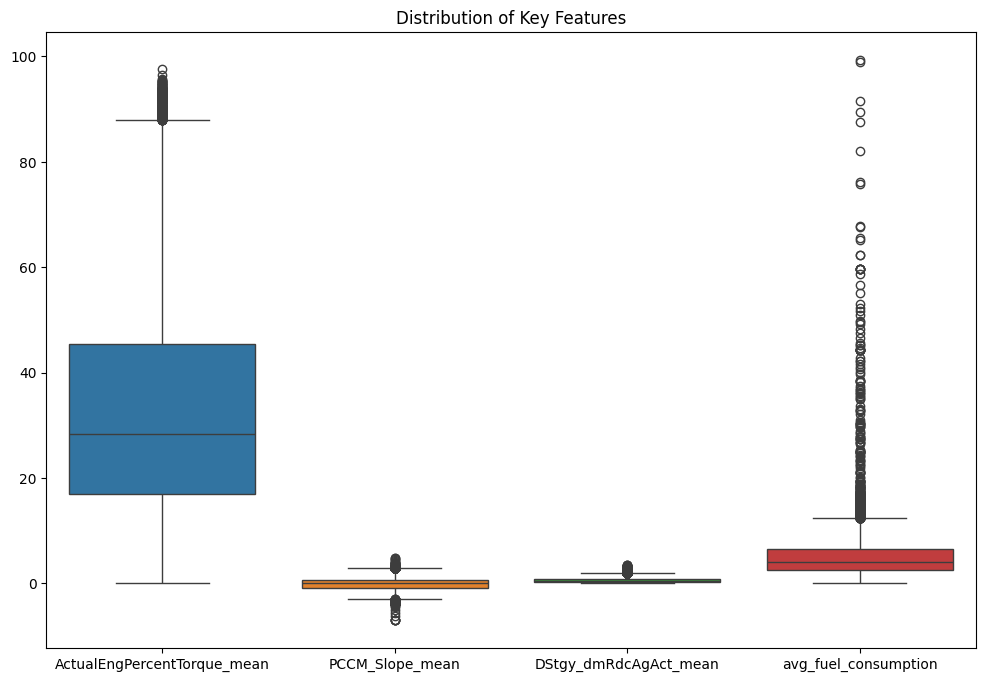

<Figure size 1200x800 with 0 Axes>

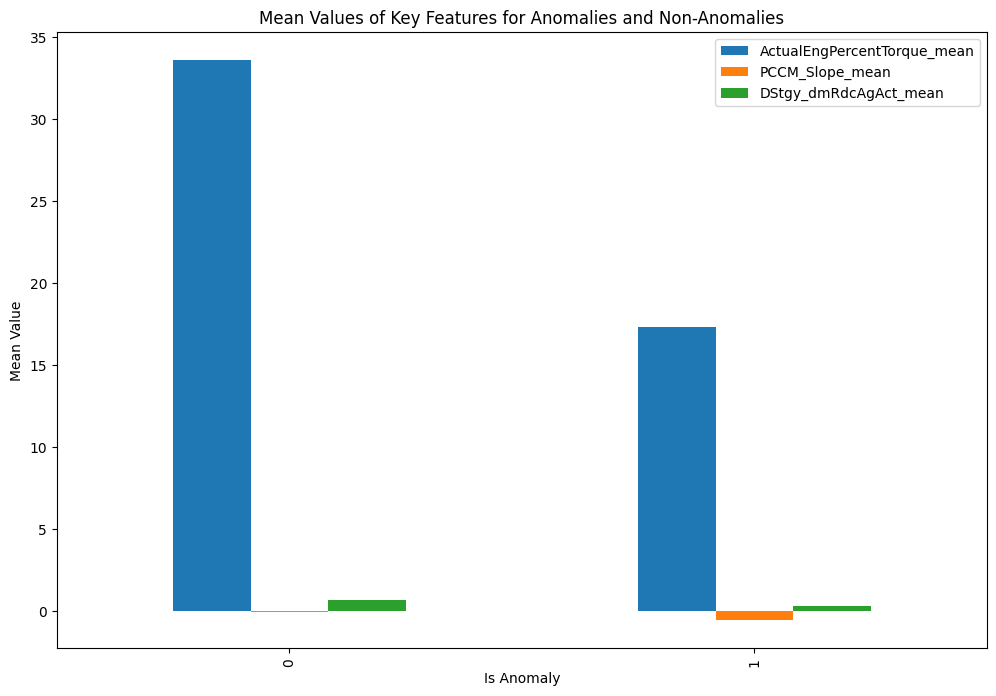

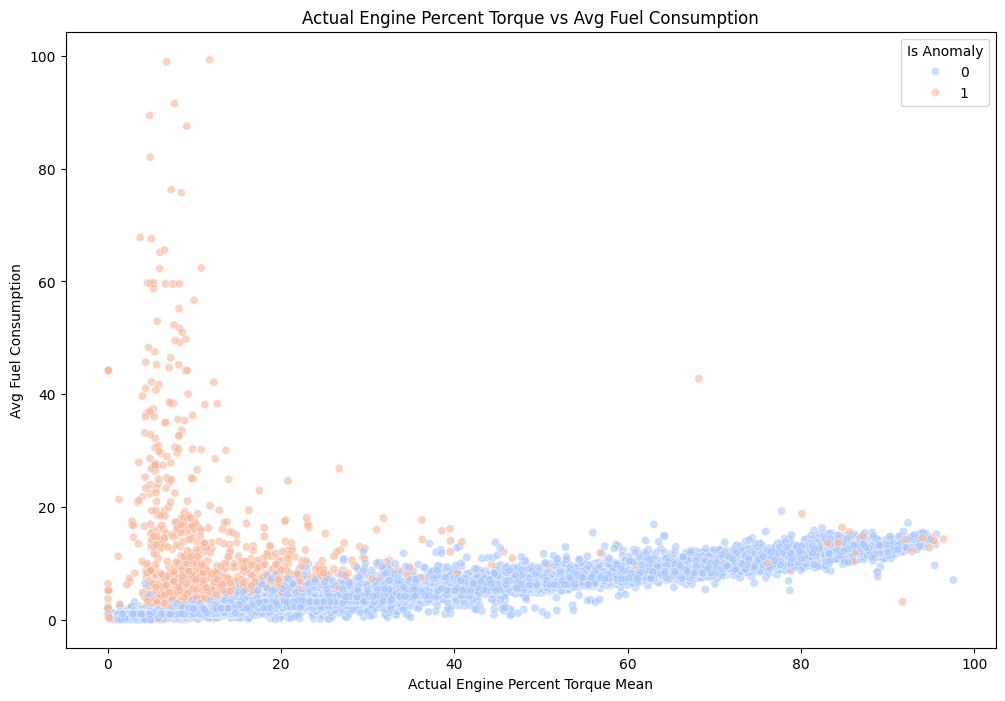

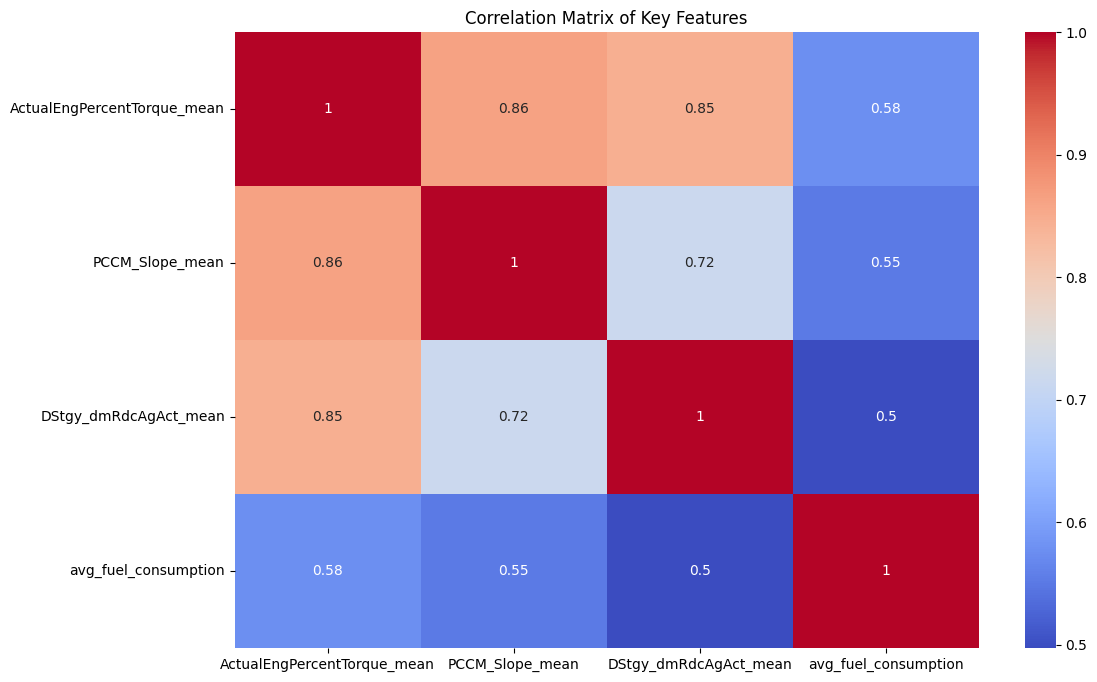

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.boxplot(data=adjusted_df_autoencoder[['ActualEngPercentTorque_mean', 'PCCM_Slope_mean', 'DStgy_dmRdcAgAct_mean', 'avg_fuel_consumption']])
plt.title('Distribution of Key Features')
plt.show()
plt.figure(figsize=(12, 8))
mean_values = adjusted_df_autoencoder.groupby('is_anomaly_dynamic')[['ActualEngPercentTorque_mean', 'PCCM_Slope_mean', 'DStgy_dmRdcAgAct_mean']].mean()
mean_values.plot(kind='bar', figsize=(12, 8))
plt.title('Mean Values of Key Features for Anomalies and Non-Anomalies')
plt.xlabel('Is Anomaly')
plt.ylabel('Mean Value')
plt.show()
plt.figure(figsize=(12, 8))
sns.scatterplot(x='ActualEngPercentTorque_mean', y='avg_fuel_consumption', hue='is_anomaly_dynamic', data=adjusted_df_autoencoder, palette='coolwarm', alpha=0.6)
plt.title('Actual Engine Percent Torque vs Avg Fuel Consumption')
plt.xlabel('Actual Engine Percent Torque Mean')
plt.ylabel('Avg Fuel Consumption')
plt.legend(title='Is Anomaly')
plt.show()
plt.figure(figsize=(12, 8))
corr_matrix = adjusted_df_autoencoder[['ActualEngPercentTorque_mean', 'PCCM_Slope_mean', 'DStgy_dmRdcAgAct_mean', 'avg_fuel_consumption']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Key Features')
plt.show()
